In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random

In [ ]:
model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/TCC II/30K-4-epochs-bert-base-uncased/model",local_files_only=True)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [ ]:
all_posts_df_pos_tests = pd.read_csv('/content/drive/MyDrive/TCC II/30K-4-epochs-bert-base-uncased/all_posts_to_analyse_pos_test.csv')

In [ ]:
all_posts_df_pos_tests

,facebookId,pre_processed_message,message_min_processed,label
0,292074710916413,anderson torres chega brasilia exministro pres...,anderson torres chega a brasilia ex-ministro j...,0
1,665517103649471,presidente lula reune trabalhadores palacio pl...,presidente lula reune trabalhadores do palacio...,0
2,292074710916413,ibama sob nova direcao deputado federal rodrig...,ibama sob nova direcao o deputado federal rodr...,0
3,292074710916413,membro republica olavista londrina professor u...,o membro da republica olavista de londrina e t...,0
4,292074710916413,movimentos sociais betim mg promovem ato frent...,movimentos sociais de betim ( mg ) promovem at...,0
...,...,...,...,...
795,100068234133822,ser assim apoiamos espalhem greve geral n bras...,ja que tem que ser assim apoiamos ! espalhem !...,1
796,890711084350263,deus misericordia nacao,- que deus tenha misericordia da nossa nacao,1
797,890711084350263,rdem progresso progresso bandeira nunca vermel...,rdem e progresso progresso nossa bandeira nunc...,1
798,409388089120866,siga forapt instagram,siga @ forapt.13 no instagram,1


In [ ]:
text = all_posts_df_pos_tests.pre_processed_message.values
labels = all_posts_df_pos_tests.label.values

In [ ]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 32,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16


test_idx = list(range(len(labels)))

test_set = TensorDataset(token_id[test_idx], 
                        attention_masks[test_idx], 
                        labels[test_idx])

test_dataloader = DataLoader(
            test_set,
            sampler = SequentialSampler(test_set),
            batch_size = batch_size
        )

In [ ]:

optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
new_sentence = 'bozo'

test_ids = []
test_attention_mask = []

encoding = preprocessing(new_sentence, tokenizer)

test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

with torch.no_grad():
  output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = 'Direita' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Esquerda'


print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

Input Sentence:  bozo
Predicted Class:  Esquerda


In [ ]:
print(labels.size())
print(labels)

torch.Size([800])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [ ]:
index = 0
predictions = []

for sample in text:
  # We need Token IDs and Attention Mask for inference on the new sentence
  test_ids = []
  test_attention_mask = []

  # Apply the tokenizer
  encoding = preprocessing(sample, tokenizer)

  # Extract IDs and Attention Mask
  test_ids.append(encoding['input_ids'])
  test_attention_mask.append(encoding['attention_mask'])
  test_ids = torch.cat(test_ids, dim = 0)
  test_attention_mask = torch.cat(test_attention_mask, dim = 0)

  # Forward pass, calculate logit predictions
  with torch.no_grad():
    output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))
  index = index + 1
  prediction = np.argmax(output.logits.cpu().numpy()).flatten().item()
  print(index)
  predictions.append(prediction)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
print(predictions)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

In [ ]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [ ]:
test_accuracy, test_precision, test_recall, test_specificity = b_metrics(predictions, labels)

In [ ]:
print(len(predictions),len(labels))

800 800


In [ ]:
print('accuracy:',test_accuracy,'\nprecision:', test_precision, '\nrecall',test_recall, '\nspecificity', test_specificity)

accuracy: tensor(0.7113) 
precision: tensor(0.7407) 
recall tensor(0.6500) 
specificity tensor(0.7725)


In [ ]:
right_hit = b_tp(predictions,labels)
right_error = b_fp(predictions,labels)
left_hit = b_tn(predictions,labels)
left_error = b_fn(predictions,labels)

In [ ]:
print('acertos direita:',right_hit)
print('errors direita:',right_error)
print('acertos esquerda:',left_hit)
print('errors esquerta:',left_error)

acertos direita: tensor(260)
errors direita: tensor(91)
acertos esquerda: tensor(309)
errors esquerta: tensor(140)


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
confusion_matrix = metrics.confusion_matrix(labels, predictions)

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Esquerda', 'Direita'])

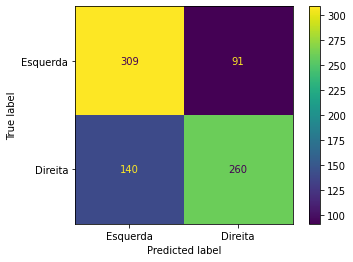

In [ ]:
cm_display.plot()
plt.show()

# Nova seção

# Nova seção

In [ ]:
all_posts_df_pos_tests['Prediction'] = predictions

In [ ]:
all_posts_df_pos_tests

,facebookId,pre_processed_message,message_min_processed,label,Prediction
0,292074710916413,anderson torres chega brasilia exministro pres...,anderson torres chega a brasilia ex-ministro j...,0,0
1,665517103649471,presidente lula reune trabalhadores palacio pl...,presidente lula reune trabalhadores do palacio...,0,0
2,292074710916413,ibama sob nova direcao deputado federal rodrig...,ibama sob nova direcao o deputado federal rodr...,0,0
3,292074710916413,membro republica olavista londrina professor u...,o membro da republica olavista de londrina e t...,0,0
4,292074710916413,movimentos sociais betim mg promovem ato frent...,movimentos sociais de betim ( mg ) promovem at...,0,0
...,...,...,...,...,...
795,100068234133822,ser assim apoiamos espalhem greve geral n bras...,ja que tem que ser assim apoiamos ! espalhem !...,1,1
796,890711084350263,deus misericordia nacao,- que deus tenha misericordia da nossa nacao,1,1
797,890711084350263,rdem progresso progresso bandeira nunca vermel...,rdem e progresso progresso nossa bandeira nunc...,1,1
798,409388089120866,siga forapt instagram,siga @ forapt.13 no instagram,1,1


In [ ]:
all_posts_df_pos_tests['hit'] = all_posts_df_pos_tests['Prediction'].eq(all_posts_df_pos_tests['label'])

In [ ]:
all_posts_df_pos_tests.to_csv('/content/drive/MyDrive/TCC II/30K-4-epochs-bert-base-uncased/results/800_all_posts_df_pos_tests_bert_base_with_predictions.csv')

In [ ]:
readed_all_posts_df_tests = pd.read_csv('/content/drive/MyDrive/TCC II/30K-4-epochs-bert-base-uncased/results/800_all_posts_df_pos_tests_bert_base_with_predictions.csv')

In [ ]:
readed_all_posts_df_tests

,Unnamed: 0,facebookId,pre_processed_message,message_min_processed,label,Prediction,hit
0,0,292074710916413,anderson torres chega brasilia exministro pres...,anderson torres chega a brasilia ex-ministro j...,0,0,True
1,1,665517103649471,presidente lula reune trabalhadores palacio pl...,presidente lula reune trabalhadores do palacio...,0,0,True
2,2,292074710916413,ibama sob nova direcao deputado federal rodrig...,ibama sob nova direcao o deputado federal rodr...,0,0,True
3,3,292074710916413,membro republica olavista londrina professor u...,o membro da republica olavista de londrina e t...,0,0,True
4,4,292074710916413,movimentos sociais betim mg promovem ato frent...,movimentos sociais de betim ( mg ) promovem at...,0,0,True
...,...,...,...,...,...,...,...
795,795,100068234133822,ser assim apoiamos espalhem greve geral n bras...,ja que tem que ser assim apoiamos ! espalhem !...,1,1,True
796,796,890711084350263,deus misericordia nacao,- que deus tenha misericordia da nossa nacao,1,1,True
797,797,890711084350263,rdem progresso progresso bandeira nunca vermel...,rdem e progresso progresso nossa bandeira nunc...,1,1,True
798,798,409388089120866,siga forapt instagram,siga @ forapt.13 no instagram,1,1,True
